In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
tf.__version__

'2.0.0'

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, 'Not enough GPU hardware devices available'
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [3]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.losses import *
from tensorflow.keras import activations

In [4]:
BATCH_SIZE = 10 
IMG_SIZE = (128,128,3)
EPOCHS = 100
NUMIMAGES = 1000
BUFFER_SIZE = 100

In [5]:
lambda_cls = 0.2
lambda_flow = 1
lambda_mask = 0.1
lambda_landmark = 10
lambda_reco = 5

In [6]:
from SectionImageLoad import *

In [7]:
from AutoEncoderModel import *
from STNFunction import *
from GeoGAN_losses import *

In [8]:
Ax_filenames_ds,By_filenames_ds,landmark_dict = load_csvdata_weneed()

In [9]:
(Ax,Ax_landmark),(By,By_landmark) = get_raw_image(Ax_filenames_ds,By_filenames_ds,landmark_dict)

In [10]:
def draw_landmark_face(raw_img,raw_landmark):
    img = np.clip((raw_img+1)/2,0,1)
    X = np.clip((raw_landmark[:,0]+1)/2*128,0,128)
    Y = np.clip((raw_landmark[:,1]+1)/2*128,0,128)
    implot = plt.imshow(img)
    plt.scatter(X,Y,c='r',s=5)
    plt.show()

In [11]:
Ax = Ax[:NUMIMAGES]
Ax_landmark = Ax_landmark[:NUMIMAGES]
By = By[:NUMIMAGES]
By_landmark = By_landmark[:NUMIMAGES]

In [12]:
Ax_ds = tf.data.Dataset.from_tensor_slices((Ax, Ax_landmark))
Ax_ds = Ax_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
By_ds = tf.data.Dataset.from_tensor_slices((By, By_landmark))
By_ds = By_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
class generator_model(Model):
    def __init__(self, img_size, batch_size, num_filter=32):
        super(generator_model, self).__init__()
        self.flowNet = autoencoder_model(num_filter,2,img_size,"channels_last","flowNet")
        self.grid_np = np.mgrid[-1:1 + 1e-7 :2 / (img_size[0] - 1), -1:1 + 1e-7:2 / (img_size[1] - 1)]
        self.grid_np = np.moveaxis(self.grid_np, [-2,-1], [0, 1])
        self.flow_grid_np = tf.convert_to_tensor(\
                                np.stack([self.grid_np]*batch_size),
                                                dtype=tf.float32)
        self.test_grid_np = tf.convert_to_tensor(self.grid_np, dtype=tf.float32)
        
        self.maskNet = autoencoder_model(num_filter,1,img_size,"channels_last","maskNet")
        self.refinementNet = autoencoder_model(num_filter,3,img_size,"channels_last","RefinementNet")
        # ------------
        self.removeResidualNet = autoencoder_model(num_filter,3,img_size,"channels_last","RemovalNet")
        
        self.removeconcat = Concatenate(axis=3)
        self.flowconcat = Concatenate(axis=3)
        self.maskconcat = Concatenate(axis=3)
        self.refineconcat = Concatenate(axis=3)
    def call(self, Ax, By, epoch, training=True):
        # Ax_flow is zeros
        fake_Ay, By_flow, raw_By_mask, raw_Ay, By_warpped = self.addAttribute(Ax,By,training)
        fake_Bx = self.removeAttribute(By,raw_By_mask,training)
        
        # fakeBx_flow is zeros
        # (Testing)fake_Ay -> raw_Ay
        fakeBx_to_By, fakeAy_flow, raw_fakeAx_mask, raw_fakeBx_to_By, _ = self.addAttribute(fake_Bx,raw_Ay,training)
        fakeAy_to_Ax = self.removeAttribute(raw_Ay,raw_fakeAx_mask,training)
        
        return_items = {}
        return_items['fake_Ay'] = fake_Ay
        return_items['fakeAy_to_Ax'] = fakeAy_to_Ax
        return_items['fakeBx_to_By'] = fakeBx_to_By
        return_items['fake_Bx'] = fake_Bx
        return_items['flows'] = [By_flow, fakeAy_flow]
        return_items['masks'] = [raw_By_mask, raw_fakeAx_mask]
        return_items['By_warpped'] = By_warpped
        # return_items['raw_Ay'] = raw_Ay
        
        return return_items
    # ----------------------------------------------------------
    def addAttribute(self,Ax,By,training):
        Ax_flow_front, By_flow_front, By_flow, By_warpped = self.callflowNet(Ax,By)
        raw_Ay, By_mask = self.callmaskNet(Ax,By_warpped)
        # Ay, residual_Ay = self.callrefineNet(raw_Ay, By_mask)
        return raw_Ay, By_flow, By_mask, raw_Ay, By_warpped
    def removeAttribute(self,By,mask,training):
        rBy = self.removeResidualNet(self.removeconcat([By,mask]))
        Bx = tf.clip_by_value(By+ 2*tf.keras.activations.tanh(rBy) ,-1,1)
        return Bx
    # ----------------------------------------------------------
    def callflowNet(self, Ax, By, training=True):
        Ax_front = self.flowNet.Encoder(Ax)
        By_front = self.flowNet.Encoder(By)
        fusion_BottleNeck = self.flowconcat([Ax_front, By_front])
        By_flow = self.flowNet.Decoder(fusion_BottleNeck)
        By_warpped = self.warp_flow(By, By_flow, training)
        return Ax_front, By_front, By_flow, By_warpped
    
    def callmaskNet(self,Ax,By_warpped,training=True):
        # maskNet
        Ax_front = self.maskNet.Encoder(Ax)
        By_warpped_front = self.maskNet.Encoder(By_warpped)
        # Blend
        bottleneck_fusion = self.maskconcat([Ax_front,By_warpped_front])
        By_mask = self.maskNet.Decoder(bottleneck_fusion)
        By_mask = Activation('sigmoid')(By_mask)
        Ay = self.blend(By_mask,Ax,By_warpped)
        return Ay, By_mask
    def callrefineNet(self,Ay,By_mask):
        mask_input = tf.stop_gradient(By_mask)
        residual_Ay = self.refinementNet(self.refineconcat([Ay, mask_input]))
        input_refineWeight = 0.1
        refineWeight = input_refineWeight
        residual_Ay = 2*tf.math.tanh(residual_Ay) * refineWeight * By_mask
        Ay = tf.clip_by_value(Ay+residual_Ay,-1,1)
        return Ay, residual_Ay
    # ----------------------------------------------------------
    def warp_flow(self, image, flow, training):
        # flow_grid = self.flow_grid_np + flow
        x_s = self.flow_grid_np[:, :, :, 1] + flow[:,:,:,0]
        y_s = self.flow_grid_np[:, :, :, 0] + flow[:,:,:,1]
        warp_image = self.bilinearSampler(image,x_s,y_s)
        return warp_image
    
    def bilinearSampler(self,image,grid_x,grid_y):
        return stn_bilinear_sampler(image,grid_x,grid_y)
    # ----------------------------------------------------------
    def blend(self,mask,a,b):
        return mask*a+(1-mask)*b
    # ----------------------------------------------------------
    def save_weights(filepath):
        self.flowNet.save_weights(filepath+'/flowNet.h5')
        self.maskNet.save_weights(filepath+'/maskNet.h5')
        self.refinementNet.save_weights(filepath+'/refinementNet.h5')
        self.removeResidualNet.save_weights(filepath+'/removeResidualNet.h5')

In [14]:
class SinglePatchDisc(Model):
                #       n_layers,input_nc,        ndf,        nc
    def __init__(self,num_layers,img_size,dis_filters,attributes):
        super(SinglePatchDisc,self).__init__()
        self.d_layers = []
        self.d_layers.append(tf.keras.Sequential([ZeroPadding2D(1),
                                           Conv2D(filters=dis_filters,kernel_size=3,strides=2,padding='valid',
                                           input_shape=img_size),
                                           LeakyReLU(alpha=0.2)]))
        nf = dis_filters
        for n in range(1,num_layers):
            nf_prev = nf
            nf = min(nf*2,512)
            self.d_layers.append(tf.keras.Sequential([ZeroPadding2D(1),
                                                      Conv2D(nf,kernel_size=3,strides=2,padding='valid'),
                                                      BatchNormalization(),
                                                      LeakyReLU(alpha=0.2)]))
        nf_prev = nf
        nf = min(nf*2,512)
        self.dilate_layer = []
        for dilate_rate in [2,4,6]:
            self.dilate_layer.append(tf.keras.Sequential([ZeroPadding2D(dilate_rate),
                                                     Conv2D(filters=nf,kernel_size=3,dilation_rate=dilate_rate,padding='valid')]))
        self.dilate_concat = Conv2D(filters=nf,kernel_size=1)
        self.disc_layer = tf.keras.Sequential([ZeroPadding2D(1),
                                               Conv2D(filters=1,kernel_size=3,strides=1,padding='valid')])
        self.attr_layer = tf.keras.Sequential([ZeroPadding2D(1),
                                               Conv2D(filters=attributes,kernel_size=3,strides=1,padding='valid'),
                                               AveragePooling2D(1),
                                               Activation('sigmoid')])
        # self.disc_layer = tf.keras.Sequential([ZeroPadding2D(1),
        #                              Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        #                              LeakyReLU(),
        #                              Dropout(0.3),
        #                              Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        #                              LeakyReLU(),
        #                              Dropout(0.3),
        #                              Flatten(),
        #                              Dense(1, activation='sigmoid')])
        # self.attr_layer = tf.keras.Sequential([ZeroPadding2D(1),
        #                              Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        #                              LeakyReLU(),
        #                              Dropout(0.3),
        #                              Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        #                              LeakyReLU(),
        #                              Dropout(0.3),
        #                             Flatten(),
        #                             Dense(1, activation='sigmoid')])
        self.dilateConcat = Concatenate(axis=3)
    def call(self, img):
        out = img
        feat = []
        for d_layer in self.d_layers:
            out = d_layer(out)
            feat.append(out)
            # if self.dilated:
        dilate_outs = []
        for idx,_ in enumerate([2,4,6]):
            layer = self.dilate_layer[idx](out)
            dilate_outs.append(layer)
        out = self.dilate_concat(self.dilateConcat([dilate_outs[0],dilate_outs[1],dilate_outs[2]]))
        disc_out = self.disc_layer(out)
        attr_out = self.attr_layer(out)
        return feat,disc_out,attr_out
class AttrbuteMultiscalePatchDisc(Model):
    def __init__(self,num_scale=3,img_size=(128,128,3),num_layers=3,dis_filters=32,attributes=1):
        super(AttrbuteMultiscalePatchDisc,self).__init__()
        self.disc = []
        self.num_scale = num_scale
        for rank in range(num_scale):
            self.disc.append(SinglePatchDisc(num_layers,img_size,dis_filters,attributes))
        self.downsampled = tf.keras.Sequential([ZeroPadding2D(1),
                                                AveragePooling2D(pool_size=3,strides=2,padding='valid')])
    def call(self,inputs):
        features, discrims = [],[]
        attr_outs = []
        image_downsampled = inputs
        for i in range(self.num_scale):
            # print("image_shape: {}".format(image_downsampled.shape))
            feat,out,attr_out = self.disc[i](image_downsampled)
            features.append(feat)
            discrims.append(out)
            attr_outs.append(attr_out)
            image_downsampled = self.downsampled(image_downsampled)
        return features,discrims,attr_outs

In [23]:
del generator
del discriminator

In [15]:
discriminator = AttrbuteMultiscalePatchDisc()

In [16]:
generator = generator_model(IMG_SIZE,BATCH_SIZE)

In [17]:
flow_loss_func = flow_loss()
lsgan_loss_func = lsgan_loss()
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [18]:
def train_flowNet_step(Ax,By,landmark_Ax,landmark_By,epoch):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        g_items = generator(Ax,By,epoch,True)
        # 1. TV_reg loss
        G_flow_loss = 0.0
        for flow in g_items['flows']:
            G_flow_loss += flow_loss_func.totalVariation_loss(flow)
        G_flow_loss = lambda_flow * tf.cast(G_flow_loss,'float32')
        # 2. landmark loss (By_flow)
        G_land_loss = flow_loss_func.landmark_loss(landmark_By,landmark_Ax,-g_items['flows'][0])
        G_land_loss = lambda_landmark * tf.cast(G_land_loss,'float32')
        # 3. recon loss
            # 3-1. mask
        G_mask_loss = 0.0
        for mask in g_items['masks']:
            G_mask_loss += recon_loss(mask,tf.zeros_like(mask))
        G_mask_loss = lambda_mask * tf.cast(G_mask_loss,'float32')
            # 3-2. add-removal recon
        G_rcon_loss = recon_loss(By,g_items['fakeBx_to_By']) + recon_loss(Ax,g_items['fakeAy_to_Ax'])
        G_rcon_loss = lambda_reco * tf.cast(G_rcon_loss,'float32')
        #-------------------------------------------
        
        # 4. GAN loss
        D_fake_loss = 0.0
        D_real_loss = 0.0
        GAN_loss = 0.0
        G_cls_loss = 0.0
        D_cls_loss = 0.0
        # -- For Generator
        for itemname in ['fake_Ay','fakeAy_to_Ax','fakeBx_to_By','fake_Bx']:
            item = g_items[itemname]
            _, pred, attr_pred = discriminator(item)
            for pred_i in pred:
                D_fake_loss += lsgan_loss_func.loss_func(pred_i, False)
                GAN_loss += lsgan_loss_func.loss_func(pred_i, True)
            D_fake_loss = D_fake_loss * 0.5
            
            for attr in attr_pred:
                if itemname in 'fake_Ay' or itemname in 'By':
                    attr_label = tf.ones_like(attr)
                else:
                    attr_label = tf.zeros_like(attr)
                G_cls_loss += lambda_cls * tf.cast(cls_loss(attr,attr_label),'float32')
        # -- For Real Data
        for (img,hasAttr) in [(Ax,False),(By,True)]:
            _, pred, attr_pred = discriminator(img)
            for pred_i in pred:
                D_real_loss += lsgan_loss_func.loss_func(pred_i, True)
            for attr in attr_pred:
                if hasAttr:
                    label = tf.ones_like(attr)
                else:
                    label = tf.zeros_like(attr)
                D_cls_loss += lambda_cls * tf.cast(cls_loss(attr,label),'float32')
        # -- CAST
        D_fake_loss = tf.cast(D_fake_loss,'float32')
        D_real_loss = tf.cast(D_real_loss,'float32')
        GAN_loss = tf.cast(GAN_loss,'float32')
        
        G_loss = G_flow_loss+G_land_loss+G_mask_loss+G_rcon_loss+G_cls_loss+GAN_loss
        D_loss = D_fake_loss+D_real_loss+D_cls_loss
    gradients_of_generator = g_tape.gradient(G_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    gradients_of_discriminator = d_tape.gradient(D_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    #print("flow_loss= {:.3f}, landmark_loss= {:.3f}, mask_loss= {:.3f}, recon_loss= {:.3f}, class_loss= {:.3f}, GAN_loss= {:.3f}".\
    #     format(G_flow_loss,G_land_loss,G_mask_loss,G_rcon_loss,G_cls_loss,GAN_loss))
    #print("D_fake_loss= {:.3f}, D_real_loss= {:.3f}, D_cls_loss= {:.3f}".format(D_fake_loss,D_real_loss,D_cls_loss))
    # print("G_loss= {:.4f}, D_loss= {:.4f}".format(G_loss,D_loss))
    return_items = {}
    return_items["G_flow_loss"] = G_flow_loss
    return_items["G_land_loss"] = G_land_loss
    return_items["G_mask_loss"] = G_mask_loss
    return_items["G_rcon_loss"] = G_rcon_loss
    return_items["G_cls_loss"] = G_cls_loss
    return_items["GAN_loss"] = GAN_loss
    return_items["D_fake_loss"] = D_fake_loss
    return_items["D_real_loss"] = D_real_loss
    return_items["D_cls_loss"] = D_cls_loss
    return_items["G_loss"] = G_loss
    return_items["D_loss"] = D_loss
    return return_items

In [19]:
# -----------------Set TensorBoard
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [20]:
lossnames = ["G_flow_loss","G_land_loss","G_mask_loss","G_rcon_loss","G_cls_loss","GAN_loss",
             "D_fake_loss","D_real_loss","D_cls_loss","G_loss","D_loss"]
metrics_list = []
for itemname in lossnames:
    metrics_list.append(tf.keras.metrics.Mean(itemname, dtype=tf.float32))

for epoch in range(1,EPOCHS+1):
    print("epoch: {}".format(epoch))
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        train_items = train_flowNet_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        for (idx, itemname) in enumerate(lossnames):
            metrics_list[idx](train_items[itemname])
    with train_summary_writer.as_default():
        for (idx, itemname) in enumerate(lossnames):
            tf.summary.scalar(itemname, metrics_list[idx].result(), step=epoch)
            metrics_list[idx].reset_states()

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100


In [39]:
for epoch in range(101,200+1):
    print("epoch: {}".format(epoch))
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        train_items = train_flowNet_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        for (idx, itemname) in enumerate(lossnames):
            metrics_list[idx](train_items[itemname])
    with train_summary_writer.as_default():
        for (idx, itemname) in enumerate(lossnames):
            tf.summary.scalar(itemname, metrics_list[idx].result(), step=epoch)
            metrics_list[idx].reset_states()

epoch: 101
epoch: 102
epoch: 103
epoch: 104
epoch: 105
epoch: 106
epoch: 107
epoch: 108
epoch: 109
epoch: 110
epoch: 111
epoch: 112
epoch: 113
epoch: 114
epoch: 115
epoch: 116
epoch: 117
epoch: 118
epoch: 119
epoch: 120
epoch: 121
epoch: 122
epoch: 123
epoch: 124
epoch: 125
epoch: 126
epoch: 127
epoch: 128
epoch: 129
epoch: 130
epoch: 131
epoch: 132
epoch: 133
epoch: 134
epoch: 135
epoch: 136
epoch: 137
epoch: 138
epoch: 139
epoch: 140
epoch: 141
epoch: 142
epoch: 143
epoch: 144
epoch: 145
epoch: 146
epoch: 147
epoch: 148
epoch: 149
epoch: 150
epoch: 151
epoch: 152
epoch: 153
epoch: 154
epoch: 155
epoch: 156
epoch: 157
epoch: 158
epoch: 159
epoch: 160
epoch: 161
epoch: 162
epoch: 163
epoch: 164
epoch: 165
epoch: 166
epoch: 167
epoch: 168
epoch: 169
epoch: 170
epoch: 171
epoch: 172
epoch: 173
epoch: 174
epoch: 175
epoch: 176
epoch: 177
epoch: 178
epoch: 179
epoch: 180
epoch: 181
epoch: 182
epoch: 183
epoch: 184
epoch: 185
epoch: 186
epoch: 187
epoch: 188
epoch: 189
epoch: 190
epoch: 191

In [ ]:
def save_images(Ax,By,Ay,epoch,batch_size):
    fig = plt.figure(figsize=(75, 75)) 
    gs = matplotlib.gridspec.GridSpec(batch_size, 3, width_ratios=[1, 1, 1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
    Ax = np.clip(Ax+1,0,1)
    By = np.clip(By+1,0,1)
    Ay = np.clip(Ay.numpy()+1,0,1)
    for i in range(batch_size):
        ax1=plt.subplot(gs[i,0])
        ax1.axis('off')
        ax2=plt.subplot(gs[i,1])
        ax2.axis('off')
        ax3=plt.subplot(gs[i,2])
        ax3.axis('off')
        ax1.imshow(Ax[i])
        ax2.imshow(By[i])
        ax3.imshow(Ay[i])
    plt.savefig('image4_at_epoch_{}.png'.format(epoch))

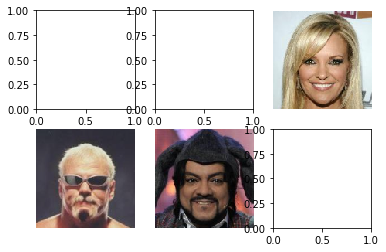

In [30]:
testAx = Ax[333]
testBy = By[333]
testAy = By[455]
fig,axes=plt.subplots(2,3)
ax1=axes[0,2]
ax1.axis('off')
ax2=axes[1,0]
ax2.axis('off')
ax3=axes[1,1]
ax3.axis('off')
ax1.imshow(testAx+1)
ax2.imshow(testBy+1)
ax3.imshow(testAy+1)
plt.savefig('image_at_epoch_test.png')

In [36]:
def save_images(Ax,By,Ay,epoch,batch_size):
    fig = plt.figure(figsize=(75, 75)) 
    gs = matplotlib.gridspec.GridSpec(batch_size, 3, width_ratios=[1, 1, 1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
    Ax = np.clip(Ax+1,0,1)
    By = np.clip(By+1,0,1)
    Ay = np.clip(Ay.numpy()+1,0,1)
    for i in range(batch_size):
        ax1=plt.subplot(gs[i,0])
        ax1.axis('off')
        ax2=plt.subplot(gs[i,1])
        ax2.axis('off')
        ax3=plt.subplot(gs[i,2])
        ax3.axis('off')
        ax1.imshow(Ax[i])
        ax2.imshow(By[i])
        ax3.imshow(Ay[i])
    plt.savefig('image3_at_epoch_{}.png'.format(epoch))

In [64]:
test_Ax_iter = iter(Ax_ds)
test_By_iter = iter(By_ds)
testAx, testAxMark = next(test_Ax_iter)
testBy, testByMark = next(test_By_iter)
test_Ax_front, test_By_front, test_By_flow, test_By_warpped = generator.callflowNet(testAx,testBy,False)
test_raw_Ay, test_By_mask = generator.callmaskNet(testAx,test_By_warpped)
testAxMark2 = tf.expand_dims(testAxMark,1)
testByMark2 = tf.expand_dims(testByMark,1)
test_sampled_flow = stn_bilinear_sampler(test_By_flow,testAxMark2[:,:,:,0],testAxMark2[:,:,:,1])

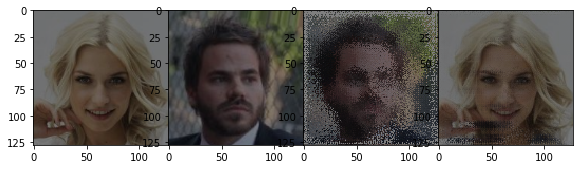

In [34]:
fig = plt.figure(figsize=(75, 75))
gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1],
        wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
img_idx = 9
imgs = [testAx[img_idx],testBy[img_idx],test_By_warpped[img_idx],test_raw_Ay[img_idx]]
for idx,img in enumerate(imgs):
    ax = plt.subplot(gs[0,idx])
    ax.imshow(np.clip((img+1)/2,0,1))

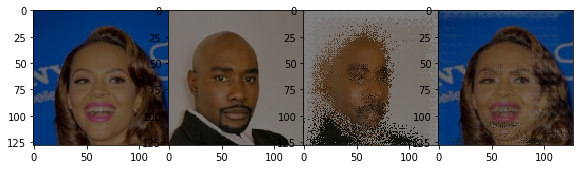

In [75]:
fig = plt.figure(figsize=(75, 75))
gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1],
        wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
img_idx = 9
imgs = [testAx[img_idx],testBy[img_idx],test_By_warpped[img_idx],test_raw_Ay[img_idx]]
for idx,img in enumerate(imgs):
    ax = plt.subplot(gs[0,idx])
    ax.imshow(np.clip((img+1)/2,0,1))
plt.savefig('test_img.png')

In [35]:
test_target_flow = (testByMark[img_idx]-testAxMark[img_idx])

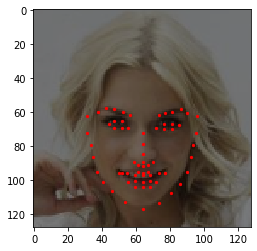

In [36]:
draw_landmark_face(testAx[img_idx],testAxMark[img_idx])

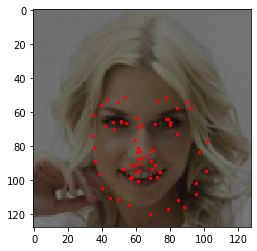

In [37]:
draw_landmark_face(testAx[img_idx],-test_sampled_flow[img_idx][0]+tf.cast(testByMark[0],'float'))

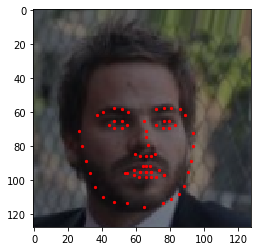

In [38]:
draw_landmark_face(testBy[img_idx],testByMark[img_idx])

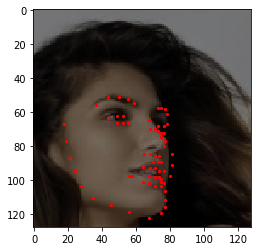

In [61]:
test_target_flow = (testByMark[img_idx]-testAxMark[img_idx])
draw_landmark_face(testAx[img_idx],testAxMark[img_idx])

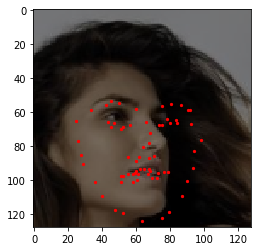

In [62]:
draw_landmark_face(testAx[img_idx],-test_sampled_flow[img_idx][0]+tf.cast(testByMark[0],'float'))

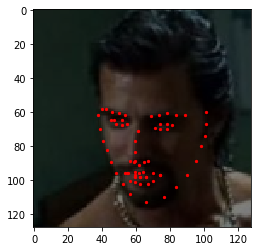

In [63]:
draw_landmark_face(testBy[img_idx],testByMark[img_idx])